In [1]:
import tqdm
import itertools
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'svg'


import boost_tree
from own_tree import UniversalTreeRegressor
from metric import special_func

In [2]:
def get_X_y(name):
    df = pd.read_csv(name)
    y = np.array(df['target'], dtype=float)
    X = np.array(df.drop(columns=['target', 'compound']), dtype=float)
    return X, y, df

In [3]:
X, y, df = get_X_y('task36.csv')
X.shape

(439, 86)

### Разбиваем на трейн/тест

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Подбираем гиперпараметры случайного леса на кросс-валидации

In [ ]:
params_random_forest = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300, 500, 1000],
    'max_depth': [5, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 3, 5, 7]
}
greedy_random_forest = GridSearchCV(RandomForestRegressor(), params_random_forest, scoring='neg_mean_squared_error', n_jobs=-1)
greedy_random_forest.fit(X_train, y_train)

In [ ]:
greedy_random_forest.best_params_

In [8]:
np.sqrt(-greedy_random_forest.best_score_)

72.44620153088847

In [5]:
random_forest = RandomForestRegressor(max_depth=20, min_samples_split=2, n_estimators=200, random_state=666)
random_forest.fit(X_train, y_train)
y_random_forest_train = random_forest.predict(X_train)
y_random_forest = random_forest.predict(X_test)
print('Train:', mean_squared_error(y_train, y_random_forest_train, squared=False))
print('Test :', mean_squared_error(y_test, y_random_forest, squared=False))

Train: 29.00421704341456
Test : 58.83292607461441


### Подбираем гиперпараметры градиентного бустинга на кросс-валидации

In [10]:
params_boosting = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300, 500],
    'max_depth': [3, 4, 5, 7, 10],
    'min_samples_split': [2, 5, 8, 10]
}
greedy_boosting = GridSearchCV(GradientBoostingRegressor(), params_boosting, scoring='neg_mean_squared_error', n_jobs=-1)
greedy_boosting.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7, 10],
                         'min_samples_split': [2, 5, 8, 10],
                         'n_estimators': [10, 50, 100, 150, 200, 250, 300,
                                          500]},
             scoring='neg_mean_squared_error')

In [11]:
greedy_boosting.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 150}

In [12]:
np.sqrt(-greedy_boosting.best_score_)

71.30958782141256

In [6]:
boosting = GradientBoostingRegressor(max_depth=4, min_samples_split=2, n_estimators=150, random_state=666)
boosting.fit(X_train, y_train)
y_boosting_train = boosting.predict(X_train)
y_boosting = boosting.predict(X_test)
print('Train:', mean_squared_error(y_train, y_boosting_train, squared=False))
print('Test :', mean_squared_error(y_test, y_boosting, squared=False))

Train: 18.221243199600487
Test : 52.2066522806634


### Создаем данные для обучения специального дерева

In [7]:
coefs = np.array([1, 0, 0], dtype=float)
G = np.array(np.hstack([
    y_train[:, None],
    y_boosting_train[:, None],
    y_random_forest_train[:, None]
]))
G_test = np.array(np.hstack([
    y_test[:, None],
    y_boosting[:, None],
    y_random_forest[:, None]
]))

In [9]:
G_def = np.zeros_like(G)
G_def[:, 0] = y_train
coefs_def = np.array([1.0, 0, 0], dtype=float)

In [8]:
t = UniversalTreeRegressor(max_depth=10, min_samples_split=2)
t.fit(X_train, G, coefs)
mean_squared_error(y_test, t.predict(X_test), squared=False)

83.6805007791558

### Перебираем гиперпараметры дерева

In [14]:
params = {
    'max_depth': [3, 4, 5, 7, 8, 9, 10, 12, 20],
    'min_samples_split': [2, 3, 5, 10],
    'gamma_1': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'mu': [0.0, 0.2, 0.4, 0.6, 0.8]
}
tree_names = set(['max_depth', 'min_samples_split'])

In [15]:
names = []
vals = []
for param_name, param_vals in params.items():
    names.append(param_name)
    vals.append(param_vals)

total = 1
for v in vals:
    total *= len(v)
    
ranges = [range(len(v)) for v in vals]

stats = []

for idxs in tqdm.tqdm(itertools.product(*ranges), total=total):
    cur_tree_params = {name: val[idx] for name, val, idx in zip(names, vals, idxs) if name in tree_names}
    cur_coefs_params = {name: val[idx] for name, val, idx in zip(names, vals, idxs) if name not in tree_names}
    
    params = boost_tree.TreeRegressionMultiMSEParams()
    params.setMaxDepth(cur_tree_params['max_depth'])
    params.setMinSamplesSplit(cur_tree_params['min_samples_split'])
    tree = boost_tree.TreeRegressorMultiMSE(params)
    
    # tree = UniversalTreeRegressor(**cur_tree_params)
    
    coefs[0] = cur_coefs_params['gamma_1']
    coefs[1] = 1.0 - coefs[0]
    coefs[2] = -cur_coefs_params['mu']
    
    if coefs.sum() <= 0:
        continue
    
    tree.fit(X_train, G, coefs)
    
    stats.append(
        [val[idx] for val, idx in zip(vals, idxs)] + [
            special_func(G, coefs, tree.predict(X_train)),
            special_func(G_test, coefs, tree.predict(X_test))
        ]
    )

df = pd.DataFrame(data=stats, columns=names + ['Train', 'Test'])
df

100%|██████████████████████████████████████| 1080/1080 [00:05<00:00, 202.25it/s]


,max_depth,min_samples_split,gamma_1,mu,Train,Test
0,3,2,0.0,0.0,8817.640060,8994.140824
1,3,2,0.0,0.2,7377.310806,7628.558838
2,3,2,0.0,0.4,5933.305490,6258.789493
3,3,2,0.0,0.6,4651.768270,4139.276779
4,3,2,0.0,0.8,2392.555383,3513.239403
...,...,...,...,...,...,...
1075,20,10,1.0,0.0,2378.921875,8953.928627
1076,20,10,1.0,0.2,2071.462362,7751.044253
1077,20,10,1.0,0.4,1639.249796,6177.560335
1078,20,10,1.0,0.6,769.159937,5152.127090


In [16]:
df.to_csv('results_task_36_train_test_split_7_to_3_random_state_666.csv')

In [17]:
df = pd.read_csv('results_task_36_train_test_split_7_to_3_random_state_666.csv')

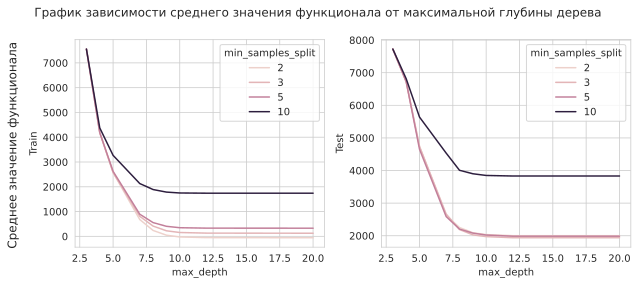

In [18]:
df_temp = df[(df['gamma_1'] == 0.2) & (df['mu'] == 0.2)]
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.lineplot(df_temp, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('График зависимости среднего значения функционала от максимальной глубины дерева')
fig.supylabel('Среднее значение функционала')
fig.tight_layout()
# fig.savefig('data/max_depth_task36_gamma_08_mu_01.svg')
plt.show()

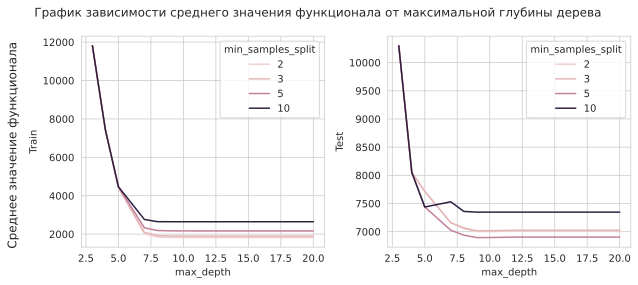

In [25]:
df_temp = df[(df['gamma_1'] == 1.0) & (df['mu'] == 0.0)]
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.lineplot(df_temp, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('График зависимости среднего значения функционала от максимальной глубины дерева')
fig.supylabel('Среднее значение функционала')
fig.tight_layout()
# fig.savefig('data/max_depth_task36_gamma_08_mu_05.svg')
plt.show()

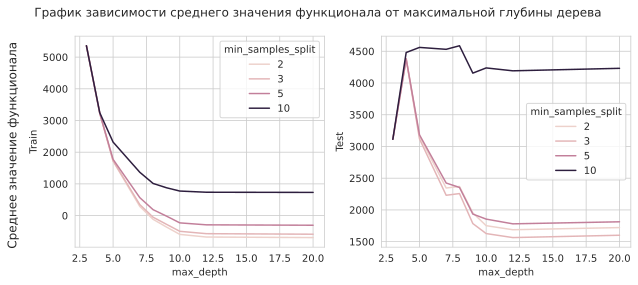

In [16]:
df_temp = df[(df['gamma_1'] == 0.8) & (df['mu'] == 0.6)]
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.lineplot(df_temp, x='max_depth', y='Train', hue='min_samples_split', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='min_samples_split', ax=axes[1])
fig.suptitle('График зависимости среднего значения функционала от максимальной глубины дерева')
fig.supylabel('Среднее значение функционала')
fig.tight_layout()
# fig.savefig('data/max_depth_task36_gamma_08_mu_05.svg')
plt.show()

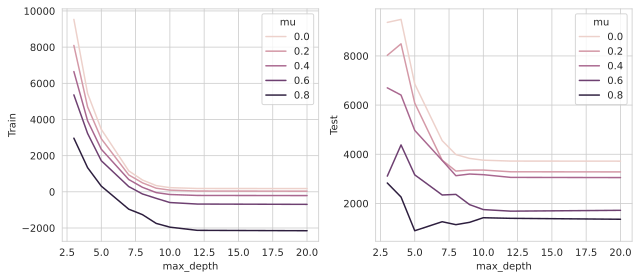

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
df_temp = df[(df['gamma_1'] == 0.8) & (df['min_samples_split'] == 2)]
sns.lineplot(df_temp, x='max_depth', y='Train', hue='mu', ax=axes[0])
sns.lineplot(df_temp, x='max_depth', y='Test', hue='mu', ax=axes[1])
fig.tight_layout()
plt.show()

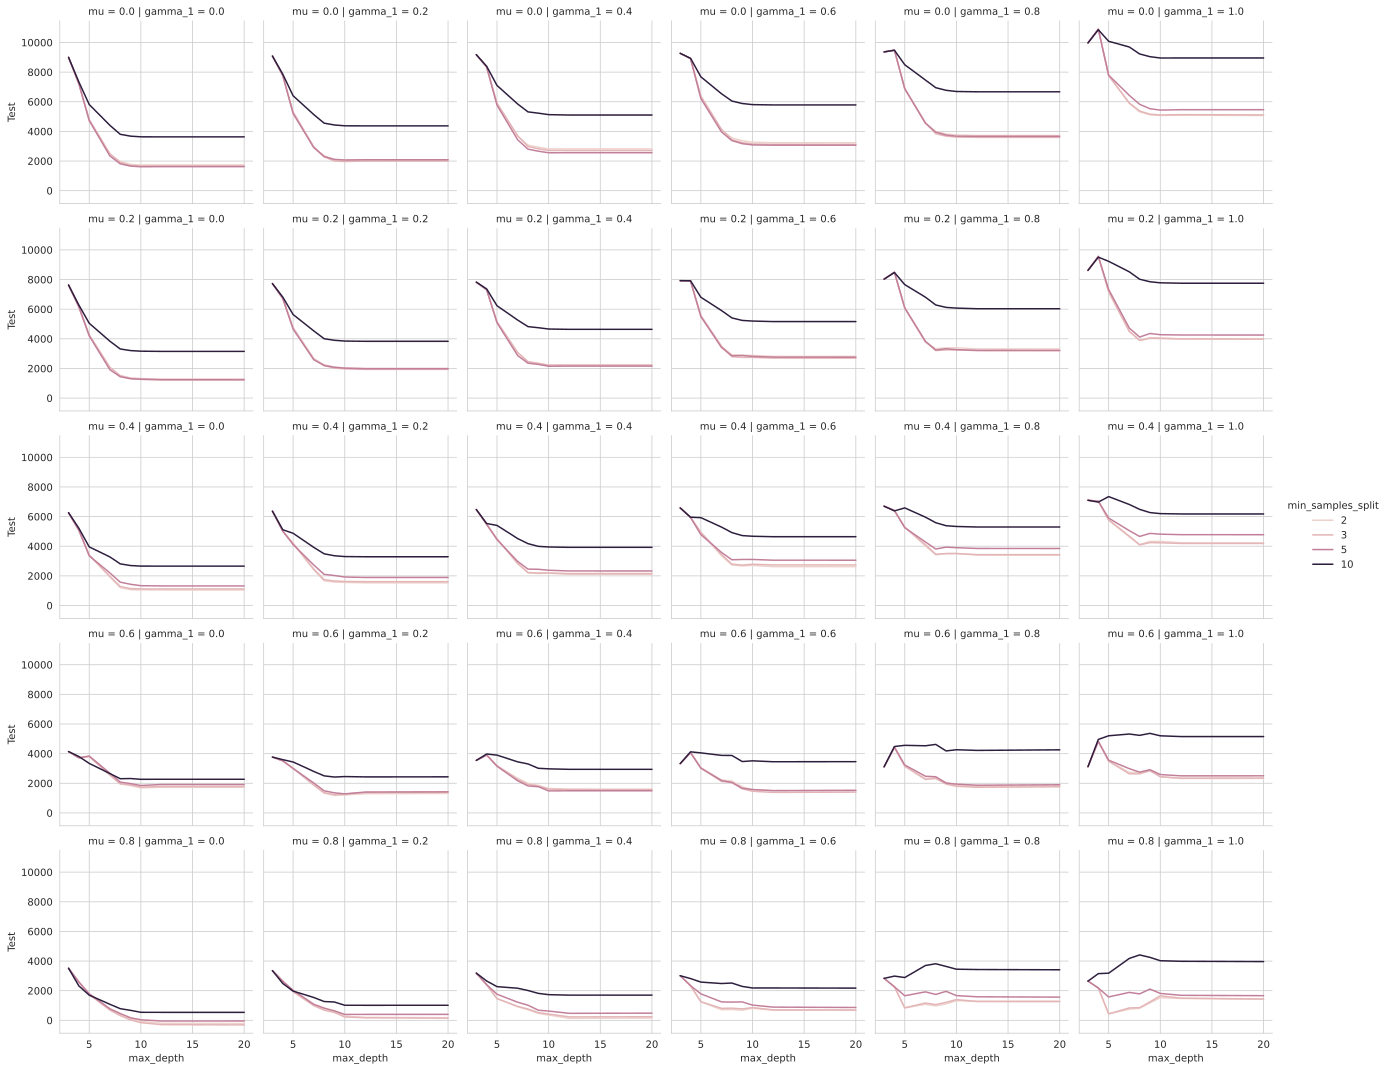

In [19]:
sns.relplot(df, x='max_depth', y='Test', row='mu', col='gamma_1', kind='line', hue='min_samples_split', height=3)

In [16]:
coefs

array([ 1. ,  0. , -0.8])

In [17]:
pred = np.dot(G.mean(axis=0), coefs) / coefs.sum()

In [18]:
np.dot(((G - pred) ** 2).sum(axis=0), coefs)

3025764.8735643774

In [20]:
norm = np.dot((G ** 2).sum(axis=0), coefs)

In [23]:
norm - (np.dot(G.mean(axis=0), coefs) ** 2) * G.shape[0] / coefs.sum()

3025764.8735643476

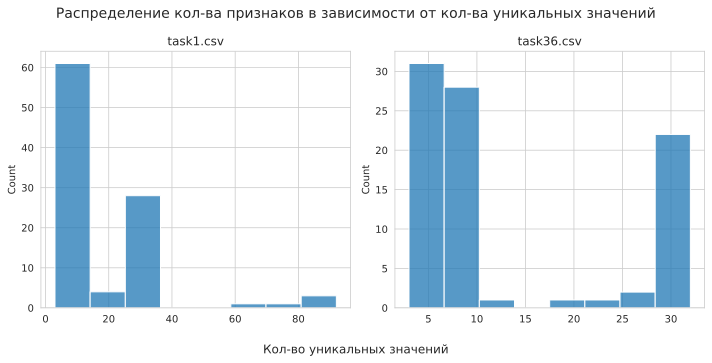

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_, _, df = get_X_y('task1.csv')
y = df['target']
df = df.drop(['compound', 'target'], axis=1)

sns.histplot([df[col].nunique() for col in df.columns], ax=axes[0])
axes[0].set_title('task1.csv')

_, _, df = get_X_y('task36.csv')
y = df['target']
df = df.drop(['compound','target'], axis=1)

sns.histplot([df[col].nunique() for col in df.columns], ax=axes[1])
axes[1].set_title('task36.csv')

fig.suptitle('Распределение кол-ва признаков в зависимости от кол-ва уникальных значений', fontsize=14)
fig.supxlabel('Кол-во уникальных значений')

fig.tight_layout()

fig.savefig('data/dists.pdf', bbox_inches='tight')
plt.show()

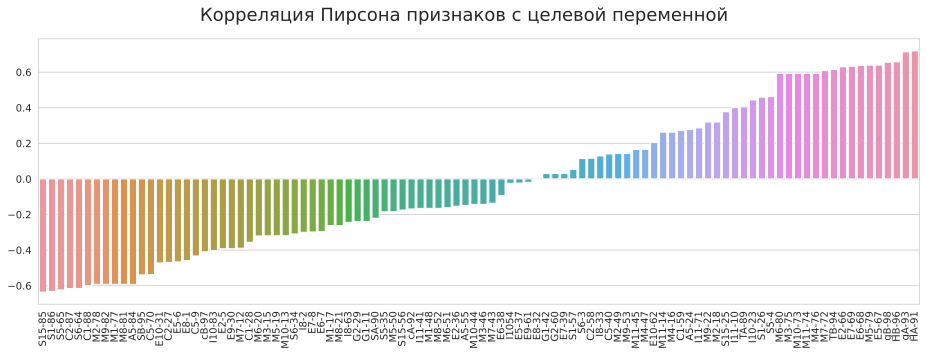

In [45]:
_, _, df = get_X_y('task1.csv')
y = df['target']
df = df.drop(['compound','target'], axis=1)

temp = df.corrwith(y).sort_values()
fig, axes = plt.subplots(1, 1, figsize=(13, 5))
smth = sns.barplot(y=temp.values, x=temp.index, ax=axes)
for item in smth.get_xticklabels():
    item.set_rotation(90)
fig.suptitle('Корреляция Пирсона признаков с целевой переменной', fontsize=18)
fig.tight_layout()
fig.savefig('data/corr_task1.pdf', bbox_inches='tight')
plt.show()

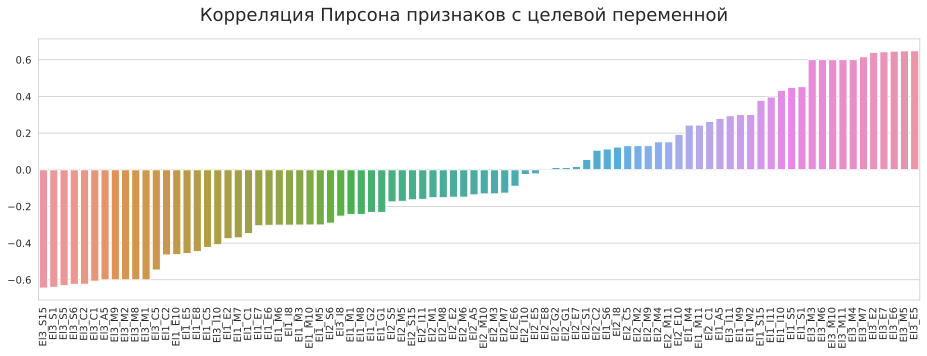

In [46]:
_, _, df = get_X_y('task36.csv')
y = df['target']
df = df.drop(['compound','target'], axis=1)

temp = df.corrwith(y).sort_values()
fig, axes = plt.subplots(1, 1, figsize=(13, 5))
smth = sns.barplot(y=temp.values, x=temp.index, ax=axes)
for item in smth.get_xticklabels():
    item.set_rotation(90)
fig.suptitle('Корреляция Пирсона признаков с целевой переменной', fontsize=18)
fig.tight_layout()
fig.savefig('data/corr_task36.pdf', bbox_inches='tight')
plt.show()